In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

## Read the data

In [2]:
columns=['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']
glass_type=pd.read_csv("https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Glass%20Identification/Glass%20Identification.csv",
                       header=None)
glass_type.columns=columns
glass_type

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [3]:
glass_type['Type_bin']=np.where(glass_type.Type<5,0,1)
glass_type

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Type_bin
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1,0
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1,0
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1,0
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1,0
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7,1
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7,1
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7,1
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7,1


## EDA

In [4]:
glass_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        214 non-null    int64  
 1   RI        214 non-null    float64
 2   Na        214 non-null    float64
 3   Mg        214 non-null    float64
 4   Al        214 non-null    float64
 5   Si        214 non-null    float64
 6   K         214 non-null    float64
 7   Ca        214 non-null    float64
 8   Ba        214 non-null    float64
 9   Fe        214 non-null    float64
 10  Type      214 non-null    int64  
 11  Type_bin  214 non-null    int32  
dtypes: float64(9), int32(1), int64(2)
memory usage: 19.4 KB


In [5]:
glass_type.drop(columns=['Id','Type'],inplace=True)
glass_type

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_bin
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,1
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,1
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,1
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,1


In [6]:
glass_type_eda=glass_type.copy()
glass_type_eda['Type_text']=np.where(glass_type_eda.Type_bin==0,'Window Glass','Non-Window Glass')
glass_type_eda.drop(columns=['Type_bin'],inplace=True)
glass_type_eda

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_text
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,Window Glass
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,Window Glass
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,Window Glass
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,Window Glass
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,Window Glass
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,Non-Window Glass
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,Non-Window Glass
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,Non-Window Glass
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,Non-Window Glass


In [7]:
glass_type_eda.Type_text.value_counts(normalize=True)

Type_text
Window Glass        0.761682
Non-Window Glass    0.238318
Name: proportion, dtype: float64

### Univariate Analysis

In [8]:
glass_type_eda.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


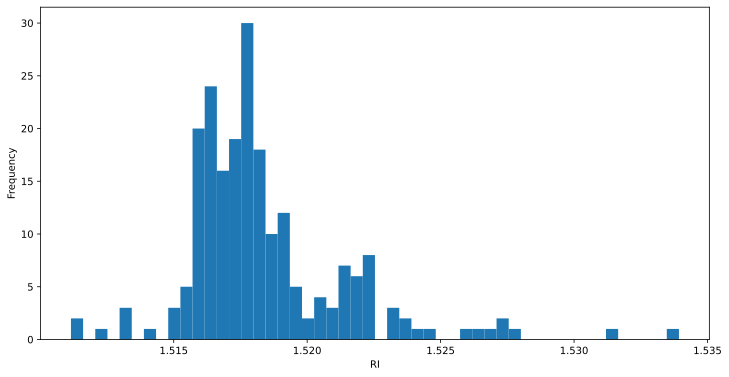

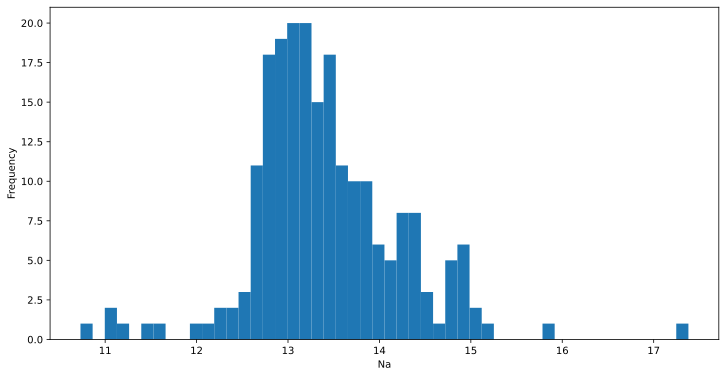

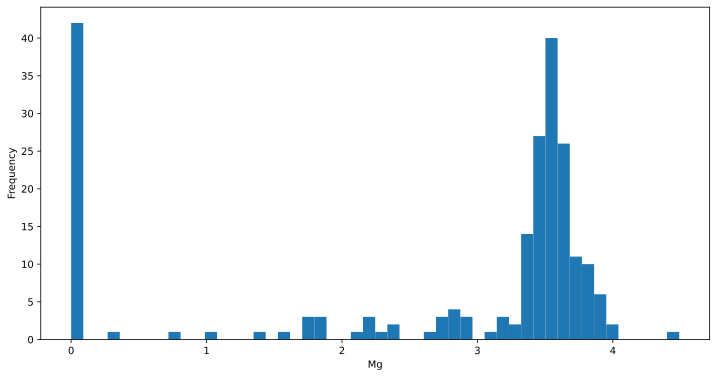

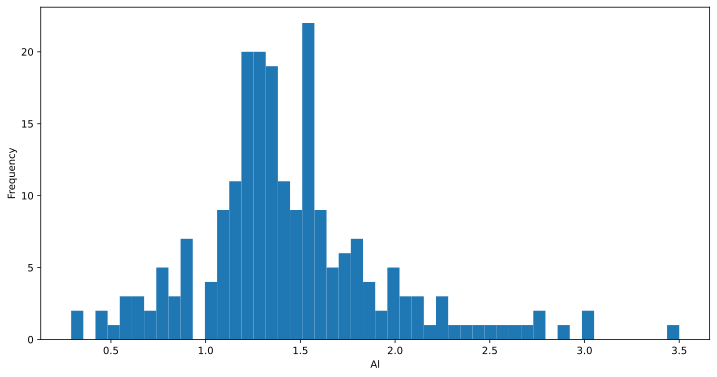

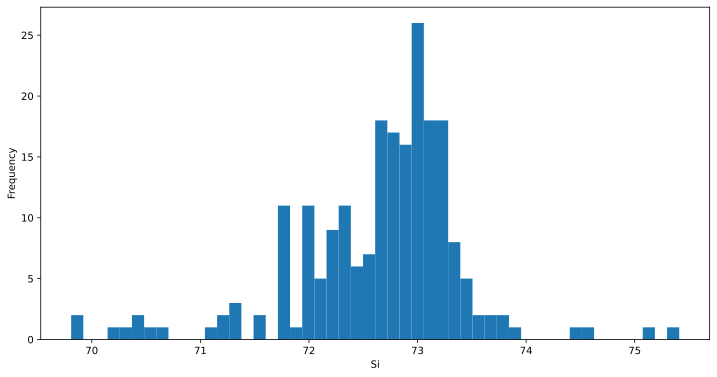

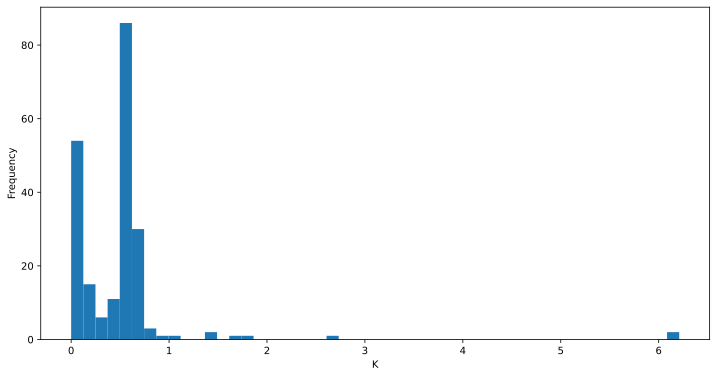

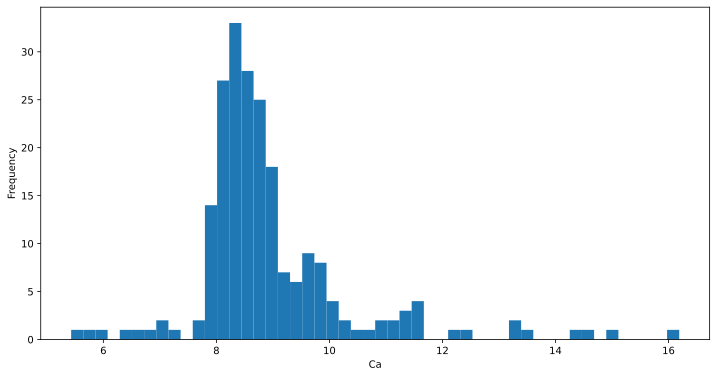

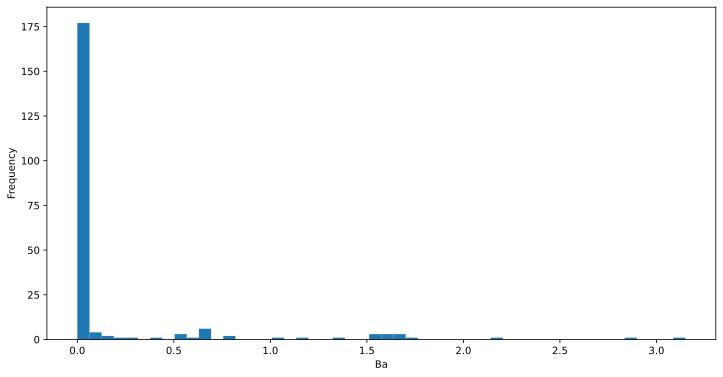

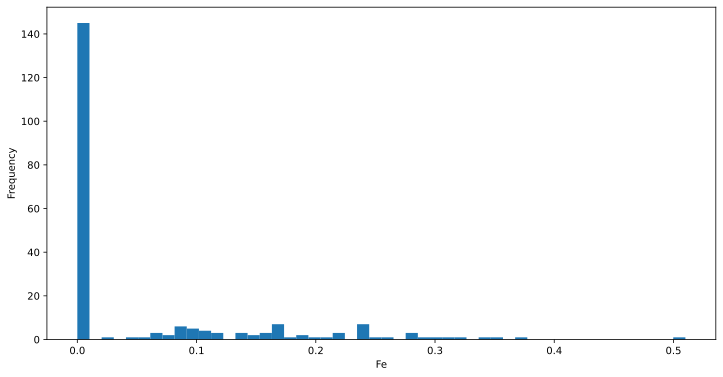

In [9]:
for col in glass_type_eda.iloc[:,:-1].columns.values:
    plt.figure(figsize=(12,6))
    glass_type_eda[col].plot.hist(bins=50)
    plt.xlabel(col)
    plt.show()

### Bivariate Analysis

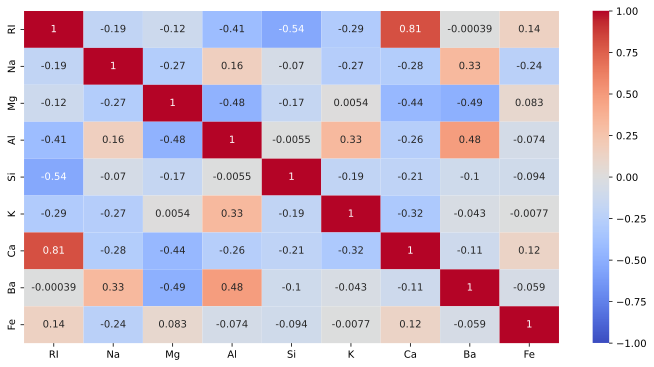

In [10]:
plt.figure(figsize=(12,6))
sns.heatmap(data=glass_type_eda.drop(columns=['Type_text']).corr(),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)
plt.show()

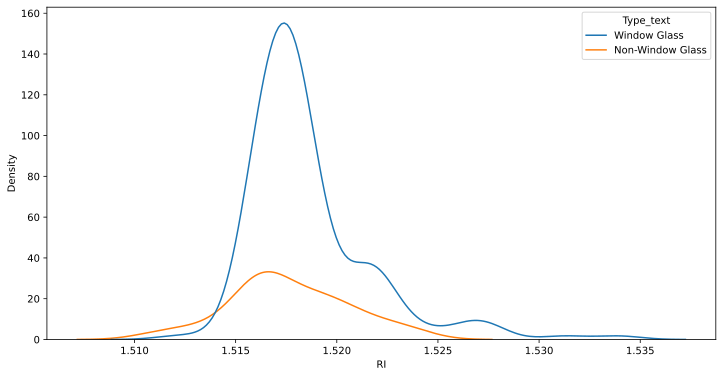

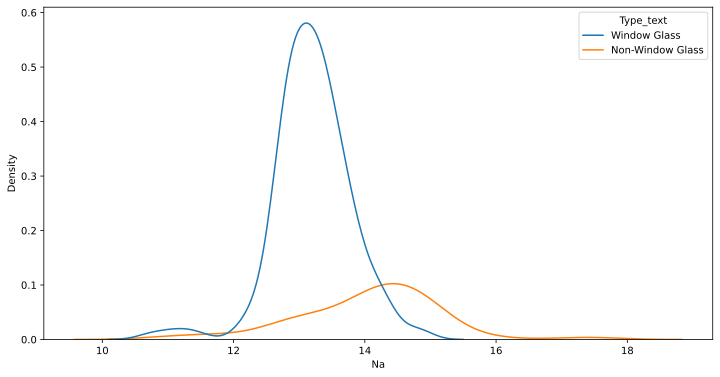

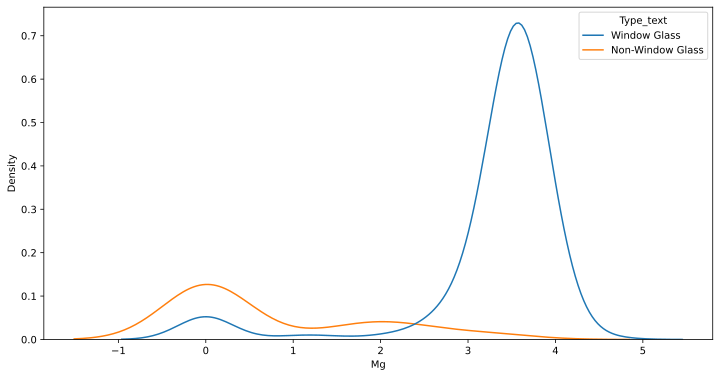

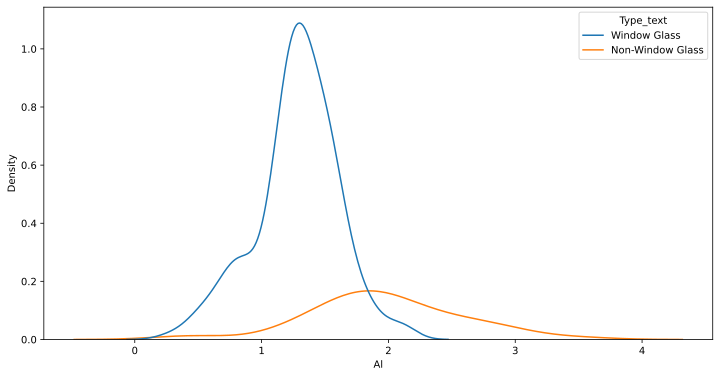

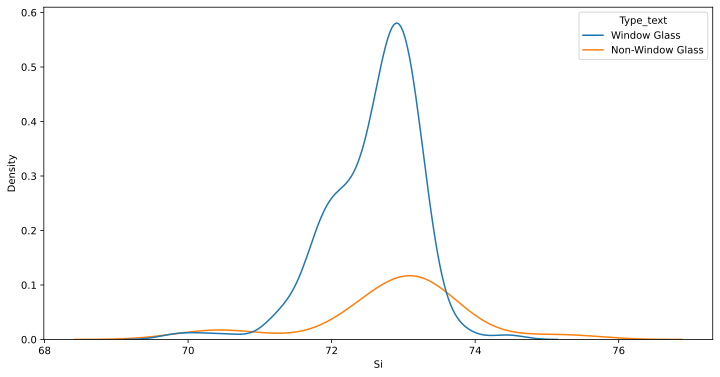

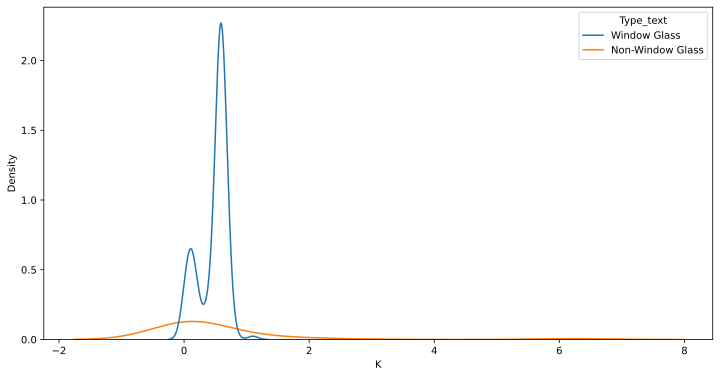

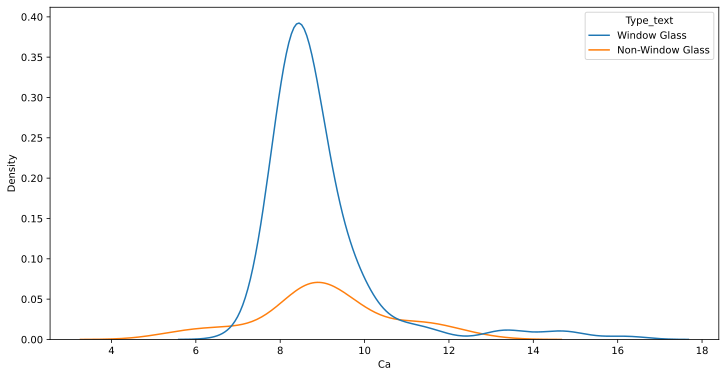

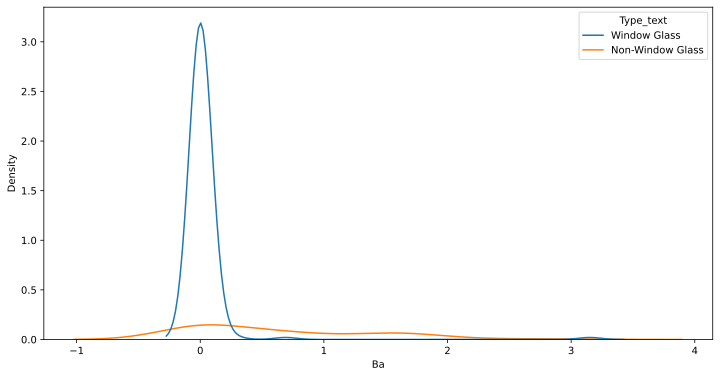

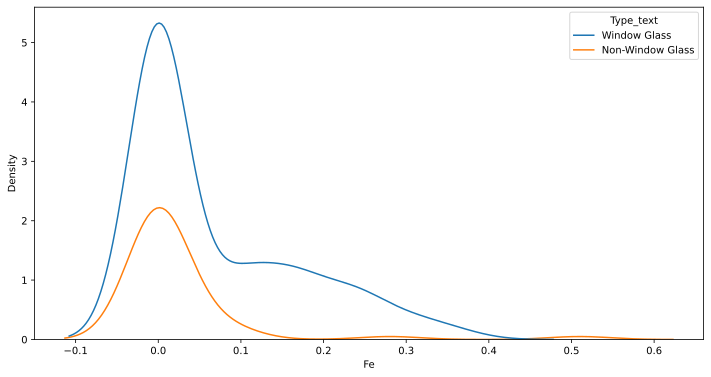

In [11]:
for col in glass_type_eda.iloc[:,:-1].columns.values:
    plt.figure(figsize=(12,6))
    sns.kdeplot(hue='Type_text',x=col,data=glass_type_eda)
    plt.xlabel(col)
    plt.show()

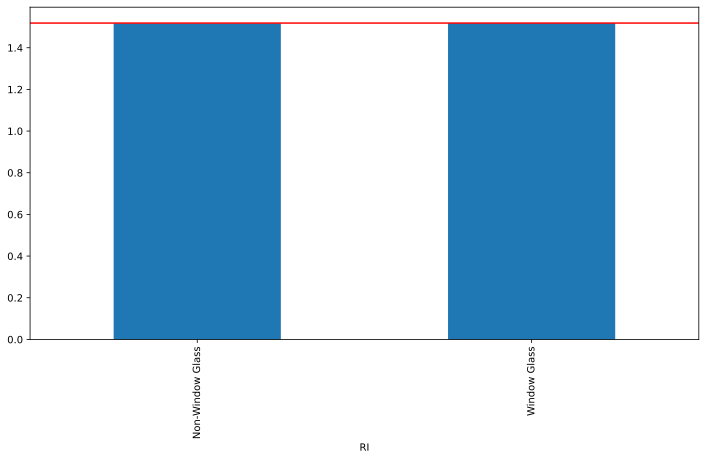

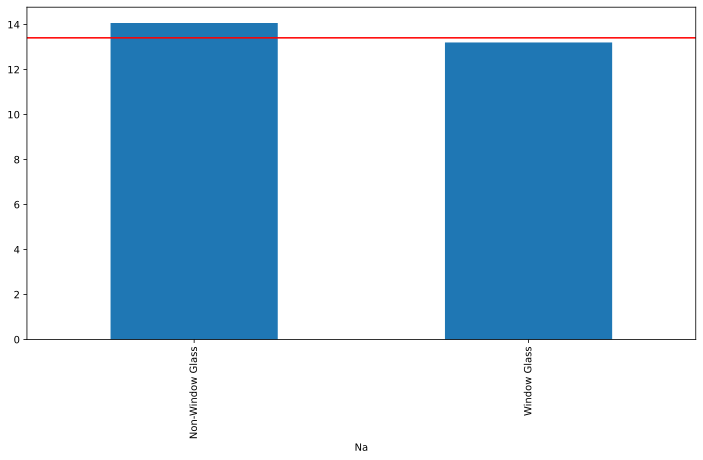

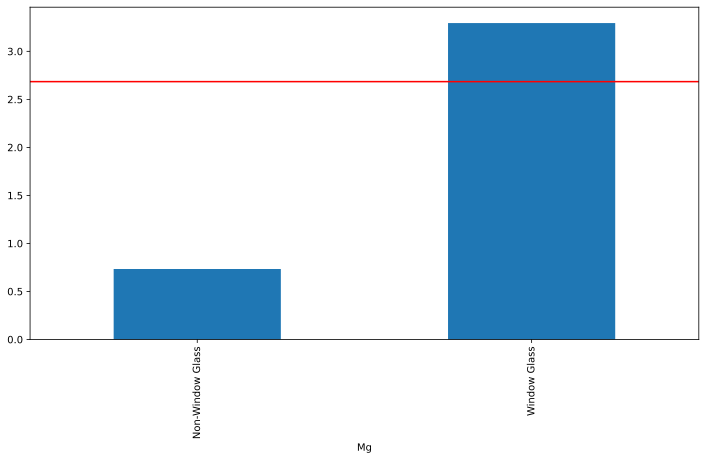

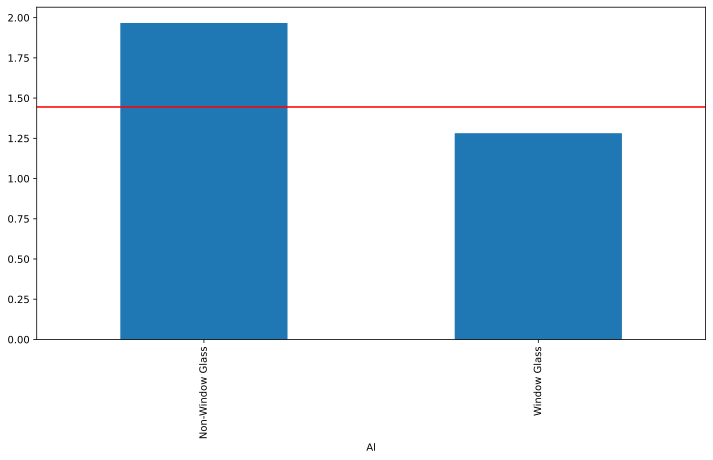

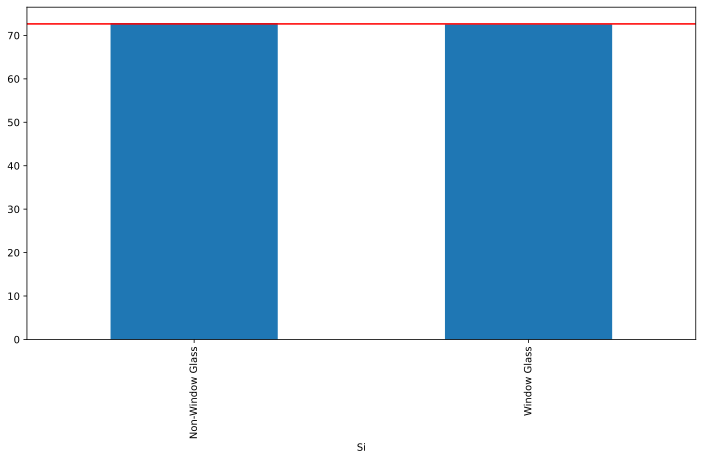

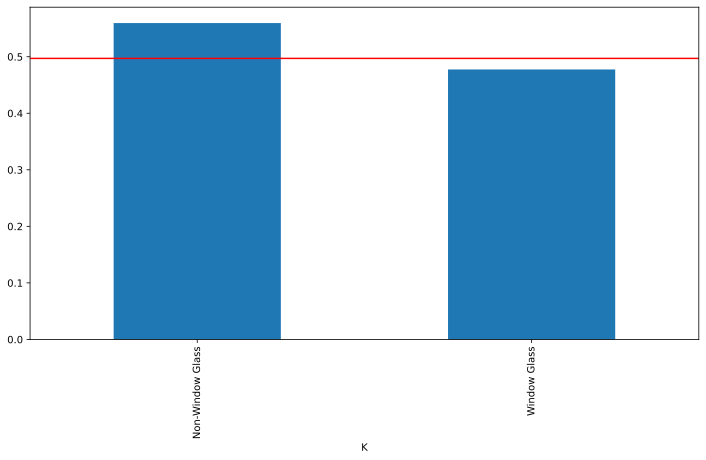

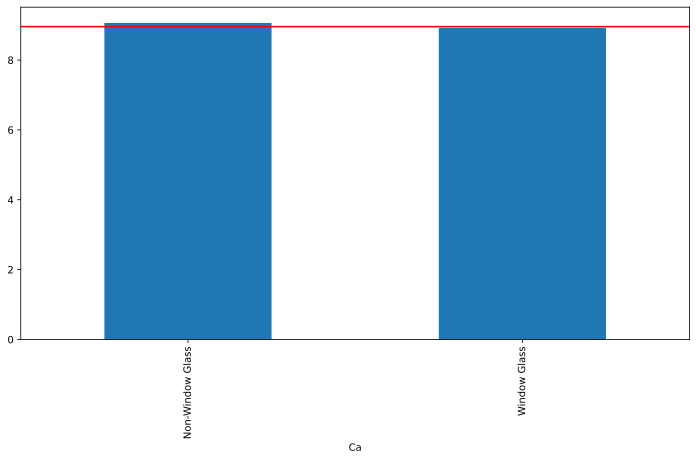

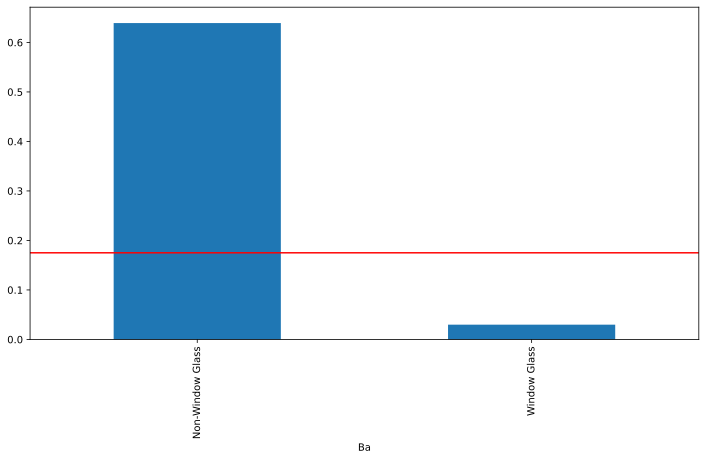

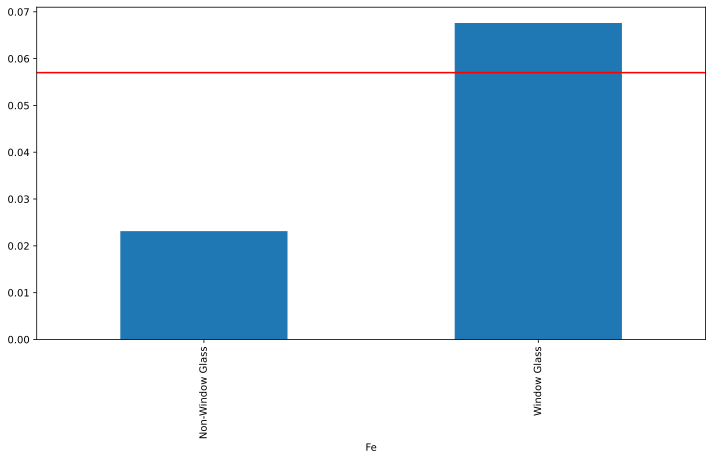

In [12]:
for col in glass_type_eda.iloc[:,:-1].columns.values:
    plt.figure(figsize=(12,6))
    glass_type_eda.groupby('Type_text')[col].mean().plot.bar()
    plt.axhline(y=glass_type_eda[col].mean(),color='red')
    plt.xlabel(col)
    plt.show()

### Data Preparation

In [13]:
X,y=glass_type.drop(columns=['Type_bin'],axis=1),glass_type['Type_bin']
scaler=MinMaxScaler()
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               shuffle=True,
                                               stratify=y,
                                               random_state=42)

scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Model Building

In [14]:
for rs in range(1,1001):
    score_dict={}
    model=RandomForestClassifier(random_state=rs,
                                 class_weight='balanced')
    cw=compute_class_weight(class_weight='balanced',
                     classes=np.unique(y),
                     y=y)
    sample_weight=np.where(y_train==0,cw[0],cw[-1])
    cv=10
    cv_scores=cross_val_score(estimator=model,
                              X=X_train_scaled,
                              y=y_train,
                              cv=cv,
                              scoring='roc_auc',
                              n_jobs=-1).mean()
    model.fit(X=X_train_scaled,
              y=y_train,
              sample_weight=sample_weight)
    y_pred_proba=model.predict_proba(X_test_scaled)[:,1]
    test_score=roc_auc_score(y_true=y_test,
                            y_score=y_pred_proba)
    score_diff=abs(test_score-cv_scores)
    score_dict[rs]=[cv_scores,test_score,score_diff]

best_rs=min(score_dict,key=lambda x:score_dict[x][-1])

print(f'Best Random State: {best_rs}')
print(f'Best CV Score: {score_dict[best_rs][0]}')
print(f'Best Test Score: {score_dict[best_rs][1]}')
print(f'Least Score difference: {score_dict[best_rs][-1]}')

Best Random State: 1000
Best CV Score: 0.9923076923076923
Best Test Score: 0.9454545454545454
Least Score difference: 0.0468531468531469


### Hyperparameter Tuning

In [15]:
model=RandomForestClassifier(random_state=best_rs,
                             class_weight='balanced')
n_estimators = np.linspace(start = 100, stop = 2000, num = 10).astype(np.int64)
max_features = ['log2', 'sqrt']
max_depth = np.linspace(start=10, stop=100, num=10).astype(np.int64).tolist()
max_depth.append(None)
min_samples_leaf = np.linspace(start=2,stop=10, num=5).astype(np.int64)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
optimizer=BayesSearchCV(estimator=model,
                        search_spaces=random_grid,
                        n_iter=100,
                        cv=10,
                        scoring='roc_auc',
                        n_jobs=-1)
optimizer.fit(X=X_train_scaled,
              y=y_train,
              sample_weight=sample_weight)

BayesSearchCV(cv=10,
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=1000),
              n_iter=500, n_jobs=-1, scoring='roc_auc',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, None],
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': array([ 2,  4,  6,  8, 10], dtype=int64),
                             'n_estimators': array([ 100,  311,  522,  733,  944, 1155, 1366, 1577, 1788, 2000],
      dtype=int64)})

In [20]:
best_model=RandomForestClassifier(random_state=best_rs,
                                  class_weight='balanced',
                                  **optimizer.best_params_)
cv_score=cross_val_score(estimator=best_model,
                         cv=10,
                         X=X_train_scaled,
                         y=y_train,
                         scoring='roc_auc',
                         n_jobs=-1).mean()

best_model.fit(X=X_train_scaled,
               y=y_train,
               sample_weight=sample_weight)
test_score=roc_auc_score(y_true=y_test,
                         y_score=best_model.predict_proba(X_test_scaled)[:,1])

print(f'CV Score: {cv_score}')
print(f'Test Score: {test_score}')
print(f'Score Difference: {abs(cv_score-test_score)}')

CV Score: 0.9834615384615384
Test Score: 0.9303030303030303
Score Difference: 0.05315850815850809


### Feature Importance

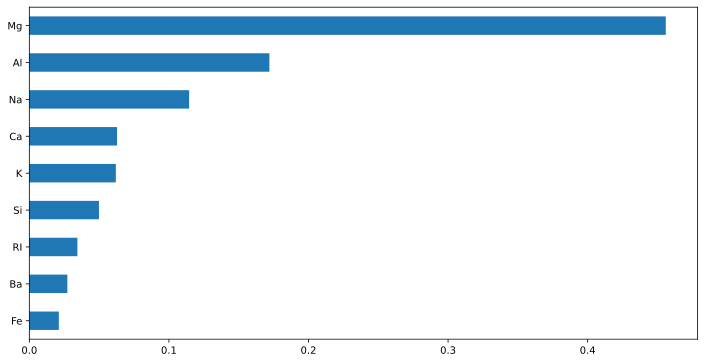

In [27]:
selected_model=RandomForestClassifier(random_state=best_rs,
                                      class_weight='balanced')
selected_model.fit(X=X_train_scaled,
                   y=y_train,
                   sample_weight=sample_weight)
plt.figure(figsize=(12,6))
pd.Series(data=selected_model.feature_importances_,index=X_test.columns.values).sort_values(ascending=True).plot.barh();

### Partial Dependence Plot

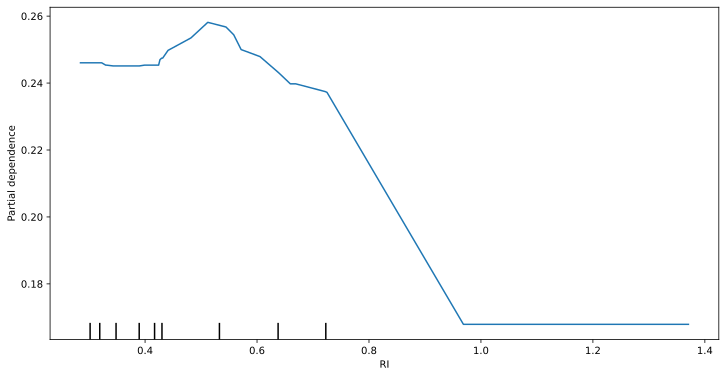

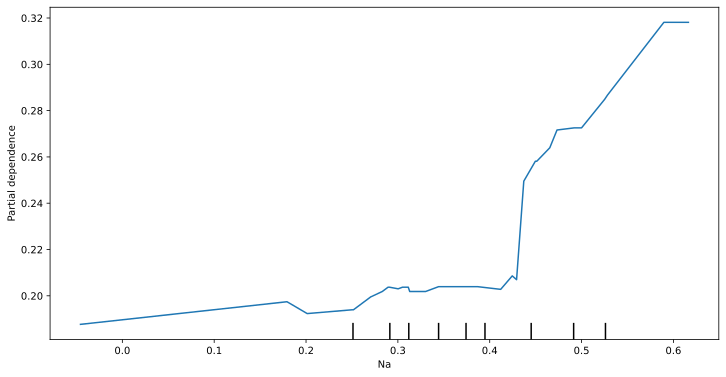

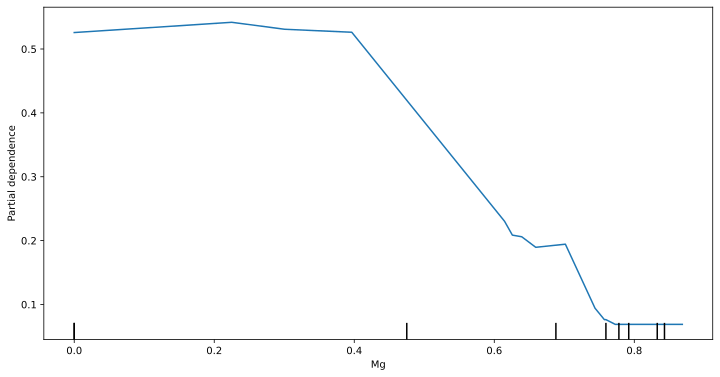

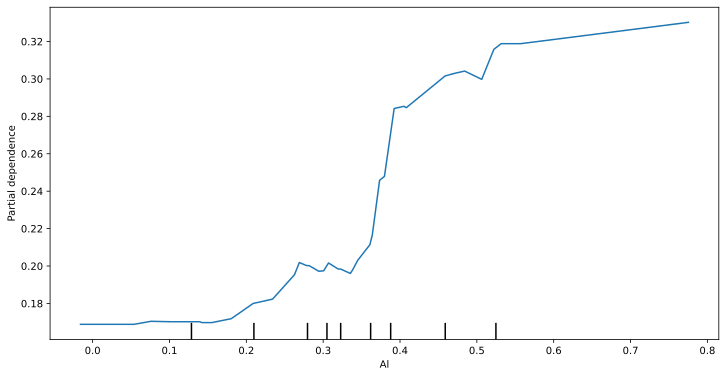

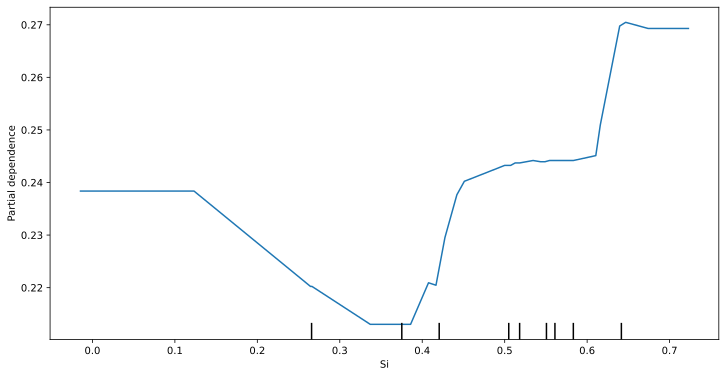

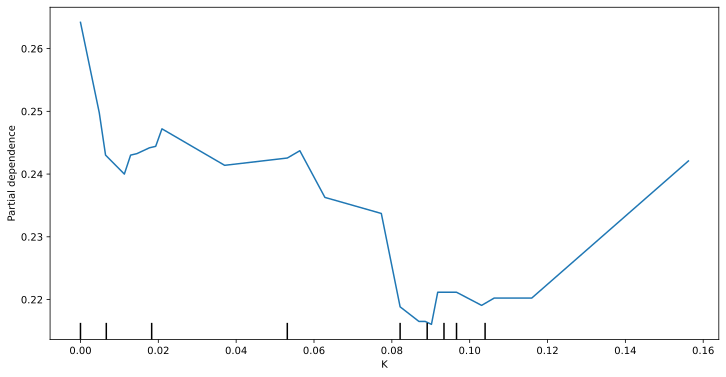

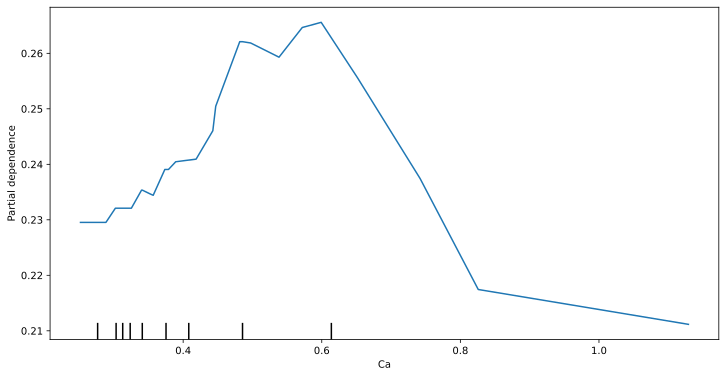

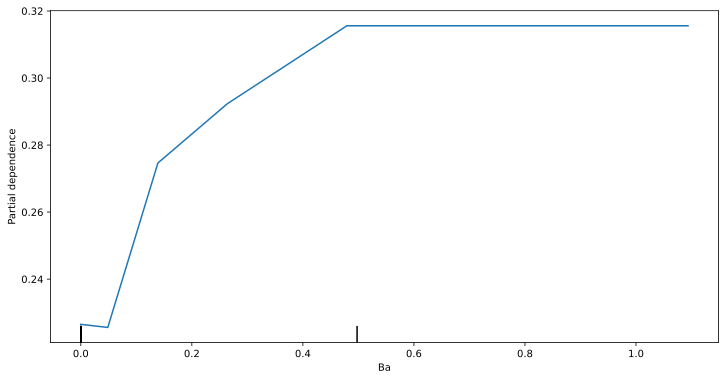

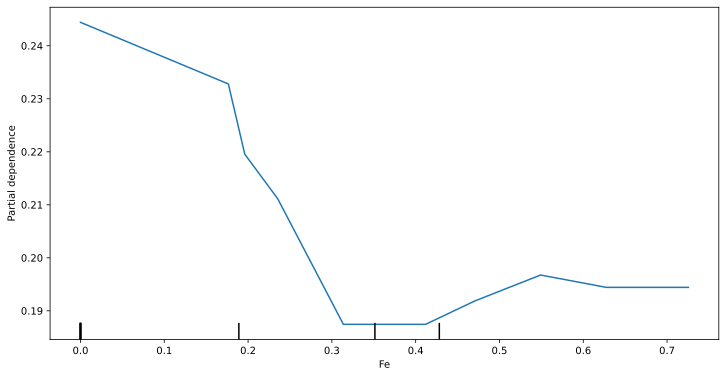

In [35]:
partial_dependence_df=pd.DataFrame(data=X_test_scaled,
                                   columns=X_test.columns.values)
for col in partial_dependence_df.columns.values:
    fig,ax=plt.subplots(1,figsize=(12,6))
    PartialDependenceDisplay.from_estimator(X=partial_dependence_df,
                                            estimator=selected_model,
                                             target=1,
                                             features=[col],
                                             n_jobs=-1,
                                             ax=ax)

### ROC Curve

In [49]:
fpr,tpr,thresholds=roc_curve(y_true=y_test,
                             y_score=selected_model.predict_proba(X=X_test_scaled)[:,-1])

In [50]:
tpr

array([0. , 0.2, 0.3, 0.6, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 1. , 1. ])

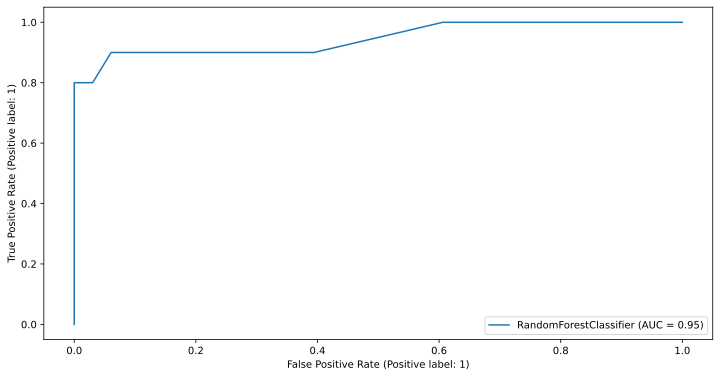

In [57]:
fig,ax=plt.subplots(1,figsize=(12,6))
RocCurveDisplay.from_estimator(estimator=selected_model,
                               X=X_test_scaled,
                                 y=y_test,
                                 ax=ax);

In [63]:
np.linspace(start=0,stop=1,num=1001)

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [69]:
cutoff_dict={}
for cutoff in np.linspace(start=0,stop=1,num=1001):
    y_pred=np.where(selected_model.predict_proba(X=X_test_scaled)[:,-1]>cutoff,1,0)
    cutoff_dict[cutoff]=f1_score(y_true=y_test,
                                 y_pred=y_pred,
                                 average='weighted')
optimal_cutoff=max(cutoff_dict,key=cutoff_dict.get)
print(f'Optimal cutoff: {optimal_cutoff}')
print(f'Optimal F1 Score: {cutoff_dict[optimal_cutoff]}')

Optimal cutoff: 0.53
Optimal F1 Score: 0.9515883872929016


In [72]:
y_pred=np.where(selected_model.predict_proba(X=X_test_scaled)[:,-1]>optimal_cutoff,1,0)
print(classification_report(y_true=y_test,
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.80      0.89        10

    accuracy                           0.95        43
   macro avg       0.97      0.90      0.93        43
weighted avg       0.96      0.95      0.95        43

